# 📂 Loading the Obesity Dataset

In this step, we will load the **Obesity dataset** into our environment for analysis.  
We’ll use **pandas** to read the file and create a DataFrame, which will make it easier to explore, clean, and prepare the data for further analysis.

In [1]:
import pandas as pd

df = pd.read_csv("pumf_cchs.csv")

In [2]:
df.head()

,ADM_RNO1,VERDATE,REFPER,GEOGPRV,GEODGHR4,DHH_SEX,DHHGMS,DHHDGHSZ,ADM_PRX,DHHGAGE,...,FSCDVHF2,INCG015,INCDGHH,INCDGRCA,INCDGRPR,INCDGRRS,ADM_040,ADM_045,ADM_050,WTS_M
0,1000,20240531,2019-2020,47.0,47906.0,2.0,1.0,2.0,2.0,3.0,...,0.0,1.0,5.0,4.0,4.0,4.0,1.0,1.0,6.0,762.82
1,100005,20240531,2019-2020,47.0,47906.0,1.0,1.0,2.0,2.0,5.0,...,0.0,2.0,4.0,2.0,2.0,2.0,6.0,1.0,6.0,31.78
2,100012,20240531,2019-2020,59.0,59914.0,2.0,2.0,1.0,2.0,5.0,...,6.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,6.0,59.24
3,100015,20240531,2019-2020,13.0,13904.0,1.0,2.0,1.0,2.0,5.0,...,0.0,2.0,3.0,3.0,3.0,9.0,6.0,1.0,6.0,22.83
4,100018,20240531,2019-2020,46.0,46903.0,1.0,2.0,1.0,2.0,4.0,...,0.0,2.0,1.0,1.0,1.0,9.0,2.0,1.0,6.0,39.96


# Hypothesis 1

### There is a significant relationship between lower income levels and the likelihood of being overweight or obese among Canadian adults.

### Data Cleaning  

Subset BMI and Income variables, kept only valid BMI codes (1, 2), and renamed columns for clarity.  

In [3]:
df_sub = df[["HWTDGISW", "INCDGHH"]].copy()

df_sub = df_sub[df_sub["HWTDGISW"].isin([1, 2])]

df_sub.rename(columns={"HWTDGISW": "BMI_cat", "INCDGHH": "Income"}, inplace=True)


### Contingency Table of Income vs. BMI  

Created a crosstab of **Income** and **BMI categories**, cleaned the Income column, and displayed all groups in a DataFrame.

In [4]:
import pandas as pd

# Contingency table (counts) using INCDGHH
contingency = pd.crosstab(df_sub["Income"], df_sub["BMI_cat"])
contingency.columns = ["Normal/Underweight", "Overweight/Obese"]

# Convert to DataFrame and clean Income column
contingency_df = contingency.reset_index()
contingency_df["Income"] = contingency_df["Income"].astype(int)

# Display all income groups
display(contingency_df)


,Income,Normal/Underweight,Overweight/Obese
0,1,2272,3069
1,2,6534,9724
2,3,6089,9523
3,4,5146,7885
4,5,16767,25263
5,9,747,1052


### BMI by Household Income  

Plotted side-by-side bars showing the number of adults in each BMI category across household income groups.  

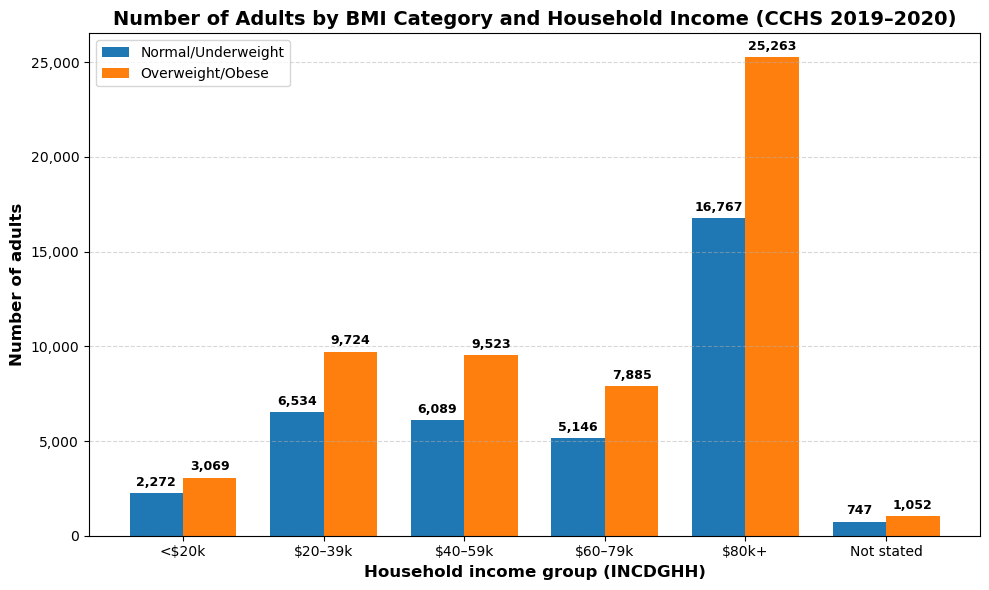

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Ensure column order
contingency_df = contingency_df[["Income", "Normal/Underweight", "Overweight/Obese"]]

# Map income codes to labels
labels_map = {
    1: "<$20k",
    2: "$20–39k",
    3: "$40–59k",
    4: "$60–79k",
    5: "$80k+",
    9: "Not stated"
}
xlabels = contingency_df["Income"].map(labels_map).tolist()

x = np.arange(len(xlabels))
width = 0.38

fig, ax = plt.subplots(figsize=(10, 6))
b1 = ax.bar(x - width/2, contingency_df["Normal/Underweight"], width, label="Normal/Underweight")
b2 = ax.bar(x + width/2, contingency_df["Overweight/Obese"], width, label="Overweight/Obese")

# Titles and labels
ax.set_title("Number of Adults by BMI Category and Household Income (CCHS 2019–2020)",
             fontsize=14, fontweight="bold")
ax.set_xlabel("Household income group (INCDGHH)", fontsize=12, fontweight="bold")
ax.set_ylabel("Number of adults", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(xlabels, rotation=0)
ax.legend()

# Value labels with thousands separator
for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f"{h:,.0f}",
                    (bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom",
                    fontsize=9, fontweight="bold")

# Grid + axis formatting
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

plt.tight_layout()
plt.show()


### Proportions of overweight/obese by income level

In [6]:
# Proportions of BMI categories within each income group
proportions = contingency.div(contingency.sum(axis=1), axis=0)
proportions.columns = ["Normal/Underweight", "Overweight/Obese"]

# Convert to DataFrame
proportions_df = proportions.reset_index()
proportions_df["Income"] = proportions_df["Income"].astype(int)

# Display proportions by income group
display(proportions_df)


,Income,Normal/Underweight,Overweight/Obese
0,1,0.425389,0.574611
1,2,0.401894,0.598106
2,3,0.390020,0.609980
3,4,0.394904,0.605096
4,5,0.398929,0.601071
5,9,0.415231,0.584769


### CI 95%

In [7]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint

g = df_sub.groupby("Income")
n = g.size()
obese = g.apply(lambda s: (s["BMI_cat"] == 2).sum())
p = obese / n

z = 1.96
se = np.sqrt(p * (1 - p) / n)

ci95_df = pd.DataFrame({
    "Income": p.index,
    "Proportion overweight/obese": p.values,
    "CI95 low": (p - z * se).clip(0, 1).values,
    "CI95 high": (p + z * se).clip(0, 1).values
})

# Reindex to ensure all income groups are present
ci95_df = ci95_df.set_index("Income").reindex([1,2,3,4,5,9]).reset_index()

display(ci95_df)

/var/folders/_w/188tytv567j0h1wnz7p5x_sw0000gn/T/ipykernel_25913/1197953382.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  obese = g.apply(lambda s: (s["BMI_cat"] == 2).sum())


,Income,Proportion overweight/obese,CI95 low,CI95 high
0,1,0.574611,0.561352,0.587871
1,2,0.598106,0.590569,0.605642
2,3,0.609980,0.602328,0.617631
3,4,0.605096,0.596702,0.613489
4,5,0.601071,0.596389,0.605752
5,9,0.584769,0.561999,0.607540


### Overweight/Obesity by Income  

Built proportions of **BMI vs. household income**, ordered categories, and plotted a bar chart showing the share of adults overweight/obese across income groups.  

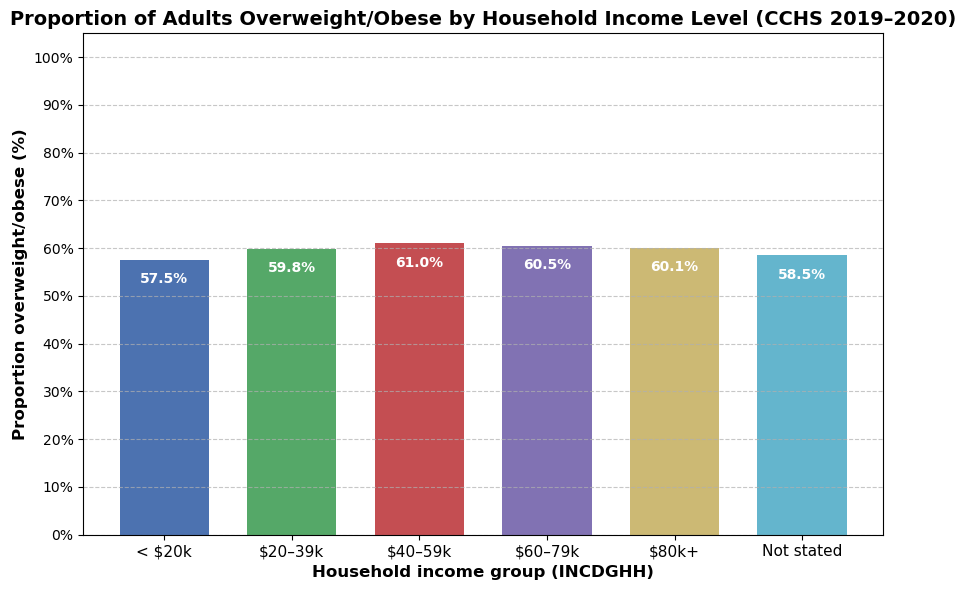

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Contingency table (counts)
contingency = pd.crosstab(df_sub["Income"], df_sub["BMI_cat"])
contingency.columns = ["Normal/Underweight", "Overweight/Obese"]

# 2) Proportions by income group (row-wise)
proportions = contingency.div(contingency.sum(axis=1), axis=0)
proportions.columns = ["Normal/Underweight", "Overweight/Obese"]

# 3) Order income categories and prepare plotting frame
order = [1, 2, 3, 4, 5, 9]  # INCDGHH groups
labels_map = {
    1: "< $20k",
    2: "$20–39k",
    3: "$40–59k",
    4: "$60–79k",
    5: "$80k+",
    9: "Not stated"
}

proportions_df = proportions.reset_index()
proportions_df["Income"] = proportions_df["Income"].astype(int)
proportions_plot = proportions_df.set_index("Income").loc[order].reset_index()

# 4) Plot
plt.figure(figsize=(9, 6))
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3", "#CCB974", "#64B5CD"]

bars = plt.bar(
    x=np.arange(len(order)),
    height=proportions_plot["Overweight/Obese"].to_numpy(),
    color=colors,
    width=0.7
)

# Bold title and axis labels
plt.title(
    "Proportion of Adults Overweight/Obese by Household Income Level (CCHS 2019–2020)",
    fontsize=14, fontweight="bold"
)
plt.xlabel("Household income group (INCDGHH)", fontsize=12, fontweight="bold")
plt.ylabel("Proportion overweight/obese (%)", fontsize=12, fontweight="bold")

# X ticks with income labels
xtick_labels = [labels_map[i] for i in order]
plt.xticks(ticks=np.arange(len(order)), labels=xtick_labels, fontsize=11, rotation=0)

# Y as percentage with grid
plt.ylim(0, 1.05)
yticks = np.linspace(0, 1, 11)
plt.yticks(yticks, [f"{int(t*100)}%" for t in yticks])
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Value labels (percent) inside bars with contrast
y_vals = proportions_plot["Overweight/Obese"].to_numpy()
for bar, val in zip(bars, y_vals):
    h = bar.get_height()
    y_pos = h - 0.04 if h >= 0.08 else h + 0.02
    color = "white" if h >= 0.08 else "black"
    plt.text(
        bar.get_x() + bar.get_width()/2,
        y_pos,
        f"{val*100:.1f}%",
        ha="center", va="center",
        fontsize=10, fontweight="bold",
        color=color
    )

plt.tight_layout()
plt.show()

### Chi-Square Test: BMI vs. Income  

Built a contingency table (BMI × income), ran a chi-square test, and reported results with Cramer’s V for effect size.  

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# 1) Minimal clean
sub = df[["HWTDGISW", "INCDGHH"]].dropna().rename(columns={
    "HWTDGISW": "BMI_cat",
    "INCDGHH": "Income"
})
sub = sub[sub["BMI_cat"].isin([1, 2]) & sub["Income"].isin([1, 2, 3, 4, 5])]  # remove 9=Not stated

# 2) Contingency table (counts)
tab = pd.crosstab(sub["Income"], sub["BMI_cat"])
tab.columns = ["Normal/Underweight", "Overweight/Obese"]

# 3) Chi-square + Cramer's V
chi2, p, dof, exp = chi2_contingency(tab)
V = np.sqrt(chi2 / (tab.to_numpy().sum() * (min(tab.shape) - 1)))

# Convert results into a DataFrame
results = pd.DataFrame({
    "Chi-square": [round(chi2, 3)],
    "Degrees of freedom": [dof],
    "p-value": [f"{p:.3e}"],
    "Cramer's V": [round(V, 3)]
})

# Display contingency table and test results
display(tab.reset_index())
display(results)

,Income,Normal/Underweight,Overweight/Obese
0,1.0,2272,3069
1,2.0,6534,9724
2,3.0,6089,9523
3,4.0,5146,7885
4,5.0,16767,25263


,Chi-square,Degrees of freedom,p-value,Cramer's V
0,22.238,4,1.797e-04,0.016


### Expected frequencies

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# 1) Clean subset (Income 1–5, BMI_cat 1–2)
sub = df[["HWTDGISW", "INCDGHH"]].dropna().rename(
    columns={"HWTDGISW": "BMI_cat", "INCDGHH": "Income"}
)
sub = sub[sub["BMI_cat"].isin([1, 2]) & sub["Income"].isin([1, 2, 3, 4, 5])]

# 2) Contingency table
tab = pd.crosstab(sub["Income"], sub["BMI_cat"])
tab.columns = ["Normal/Underweight", "Overweight/Obese"]

# 3) Chi-square test to get expected frequencies
chi2, p, dof, expected = chi2_contingency(tab)

# 4) Convert expected frequencies to DataFrame
expected_df = pd.DataFrame(
    expected.round(2),
    index=tab.index,
    columns=tab.columns
)

print("Expected frequencies table:")
display(expected_df)


Expected frequencies table:


,Normal/Underweight,Overweight/Obese
Income,,
1.0,2130.57,3210.43
2.0,6485.44,9772.56
3.0,6227.75,9384.25
4.0,5198.16,7832.84
5.0,16766.09,25263.91


### Standardized residuals

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# 1) Clean subset (keep Income=1..5, BMI_cat=1..2)
sub = df[["HWTDGISW","INCDGHH"]].dropna().rename(columns={"HWTDGISW":"BMI_cat","INCDGHH":"Income"})
sub = sub[sub["BMI_cat"].isin([1,2]) & sub["Income"].isin([1,2,3,4,5])]

# 2) Contingency table (observed)
tab = pd.crosstab(sub["Income"], sub["BMI_cat"])
tab.columns = ["Normal/Underweight", "Overweight/Obese"]

# 3) Expected + adjusted standardized residuals
chi2, p, dof, expected = chi2_contingency(tab)
exp = pd.DataFrame(expected, index=tab.index, columns=tab.columns)

n = tab.to_numpy().sum()
row_prop = tab.sum(axis=1) / n
col_prop = tab.sum(axis=0) / n

# Broadcast denominators per cell: sqrt(E * (1 - row_p_i) * (1 - col_p_j))
den = np.sqrt(exp.values * (1 - row_prop.values)[:, None] * (1 - col_prop.values)[None, :])
adj_std_resid = (tab.values - exp.values) / den

resid_df = pd.DataFrame(adj_std_resid, index=tab.index, columns=tab.columns).round(2)

print("Adjusted standardized residuals (|z| ≥ 2 often considered notable):")
display(resid_df)

# Optional: highlight notable cells
notable = resid_df.abs() >= 2
print("Notable cells (True = |residual| ≥ 2):")
display(notable)


Adjusted standardized residuals (|z| ≥ 2 often considered notable):


,Normal/Underweight,Overweight/Obese
Income,,
1.0,4.07,-4.07
2.0,0.86,-0.86
3.0,-2.49,2.49
4.0,-1.01,1.01
5.0,0.01,-0.01


Notable cells (True = |residual| ≥ 2):


,Normal/Underweight,Overweight/Obese
Income,,
1.0,True,True
2.0,False,False
3.0,True,True
4.0,False,False
5.0,False,False


# Hypothesis 2

### There is a significant relationship between lower education levels and obesity among Canadian adults.

### Checking for null values

In [12]:
df[['HWTDGISW', 'EHG2DVH3']].isnull().sum()

HWTDGISW    0
EHG2DVH3    0
dtype: int64

### Distribution Checks  

Printed frequency distributions for BMI (`HWTDGISW`) and Education (`EHG2DVH3`).  

In [13]:
# BMI distribution
bmi_counts = df['HWTDGISW'].value_counts(dropna=False)
print("BMI Distribution:")
print(bmi_counts)

# Education distribution
edu_counts = df['EHG2DVH3'].value_counts(dropna=False)
print("\nEducation Level Distribution:")
print(edu_counts)

BMI Distribution:
HWTDGISW
2.0    56516
1.0    37555
9.0     7682
6.0     6499
Name: count, dtype: int64

Education Level Distribution:
EHG2DVH3
3.0    76845
2.0    16069
1.0     9469
9.0     5869
Name: count, dtype: int64


### Cleaning the Obesity Dataset  

BMI (`HWTDGISW`) as dependent and Education Level (`EHG2DVH3`) as independent variables.  
Checked value counts, removed "skip/not stated" values, and created a cleaned dataset (`df_clean`) for analysis.  

In [14]:
import pandas as pd

# Load dataset
df = pd.read_csv("pumf_cchs.csv")

# Variables of interest
# Dependent variable: BMI (categorical)
# 0 = Normal/Underweight, 1 = Overweight/Obese, 6 = Valid skip, 9 = Not stated
bmi_col = "HWTDGISW"

# Independent variable: Education level
# 1 = Less than secondary school graduation
# 2 = Secondary school graduation with no post-secondary education
# 3 = Post-secondary certificate/diploma/university degree
# 9 = Not stated
edu_col = "EHG2DVH3"

# Quick exploration
print("Unique values in BMI:", df[bmi_col].value_counts(dropna=False))
print("Unique values in Education Level:", df[edu_col].value_counts(dropna=False))

# Count missing or 'Not stated' values
print("Skip / Not stated BMI:", df[df[bmi_col].isin([6,9])].shape[0])
print("Skip / Not stated Education Level:", df[df[edu_col]==9].shape[0])

# Optional: Filter out missing/not stated values for analysis
df_clean = df[~df[bmi_col].isin([6,9]) & (df[edu_col]!=9)]

print("Dataset shape after removing missing/not stated values:", df_clean.shape)

Unique values in BMI: HWTDGISW
2.0    56516
1.0    37555
9.0     7682
6.0     6499
Name: count, dtype: int64
Unique values in Education Level: EHG2DVH3
3.0    76845
2.0    16069
1.0     9469
9.0     5869
Name: count, dtype: int64
Skip / Not stated BMI: 14181
Skip / Not stated Education Level: 5869
Dataset shape after removing missing/not stated values: (89419, 691)


In [15]:
print("Rows removed:", df.shape[0] - df_clean.shape[0])

Rows removed: 18833


### Exploring BMI and Education Variables  

Loaded dataset, mapped BMI (`HWTDGISW`) and Education (`EHG2DVH3`) codes to descriptions, counted values (with skips/not stated), and created a cleaned dataset.

In [16]:
import pandas as pd

# Load dataset
df = pd.read_csv("pumf_cchs.csv")

# Variables of interest
# Dependent variable: BMI (categorical)
# 0 = Normal/Underweight, 1 = Overweight/Obese, 6 = Valid skip, 9 = Not stated
bmi_col = "HWTDGISW"

# Independent variable: Education level
# 1 = Less than secondary school graduation
# 2 = Secondary school graduation with no post-secondary education
# 3 = Post-secondary certificate/diploma/university degree
# 9 = Not stated
edu_col = "EHG2DVH3"

# Function to add commas
def format_counts(series):
    return series.apply(lambda x: f"{x:,}")

# Quick exploration with descriptions
bmi_counts = df[bmi_col].value_counts(dropna=False)
bmi_desc = {
    0: "Normal/Underweight",
    1: "Overweight/Obese",
    6: "Valid skip",
    9: "Not stated"
}
print("Unique values in BMI (with description):")
for val, count in bmi_counts.items():
    desc = bmi_desc.get(val, "Unknown")
    print(f"{val} ({desc}): {count:,}")

edu_counts = df[edu_col].value_counts(dropna=False)
edu_desc = {
    1: "Less than secondary school graduation",
    2: "Secondary school graduation, no post-secondary",
    3: "Post-secondary certificate/diploma/university degree",
    9: "Not stated"
}
print("\nUnique values in Education Level (with description):")
for val, count in edu_counts.items():
    desc = edu_desc.get(val, "Unknown")
    print(f"{val} ({desc}): {count:,}")

# Count missing or 'Not stated' values
print("\nSkip / Not stated BMI:", df[df[bmi_col].isin([6,9])].shape[0])
print("Skip / Not stated Education Level:", df[df[edu_col]==9].shape[0])

# Optional: Filter out missing/not stated values for analysis
df_clean = df[~df[bmi_col].isin([6,9]) & (df[edu_col]!=9)]
print("\nDataset shape after removing missing/not stated values:", df_clean.shape)

Unique values in BMI (with description):
2.0 (Unknown): 56,516
1.0 (Overweight/Obese): 37,555
9.0 (Not stated): 7,682
6.0 (Valid skip): 6,499

Unique values in Education Level (with description):
3.0 (Post-secondary certificate/diploma/university degree): 76,845
2.0 (Secondary school graduation, no post-secondary): 16,069
1.0 (Less than secondary school graduation): 9,469
9.0 (Not stated): 5,869

Skip / Not stated BMI: 14181
Skip / Not stated Education Level: 5869

Dataset shape after removing missing/not stated values: (89419, 691)


In [17]:
# Cross-tabulation of BMI by Education (counts)
ct_counts = pd.crosstab(df_clean['HWTDGISW'], df_clean['EHG2DVH3'])
print("Cross-tabulation (counts):")
print(ct_counts.apply(lambda x: x.map("{:,}".format)))  # adds commas

# Cross-tabulation of BMI by Education (percentages by education level)
ct_percent = pd.crosstab(df_clean['HWTDGISW'], df_clean['EHG2DVH3'], normalize='columns') * 100
print("\nCross-tabulation (percentages by education level):")
print(ct_percent.apply(lambda x: x.map("{:.1f}%".format)))  # adds % sign

Cross-tabulation (counts):
EHG2DVH3    1.0    2.0     3.0
HWTDGISW                      
1.0       3,011  5,380  27,322
2.0       5,361  8,980  39,365

Cross-tabulation (percentages by education level):
EHG2DVH3    1.0    2.0    3.0
HWTDGISW                     
1.0       36.0%  37.5%  41.0%
2.0       64.0%  62.5%  59.0%


In [18]:
print(df["EHG2DVH3"].unique())

[3. 2. 1. 9.]


### Distribution of Education Levels  

Mapped education codes to labels, calculated counts/percentages, and plotted a bar chart with values and percentages displayed on each bar.  

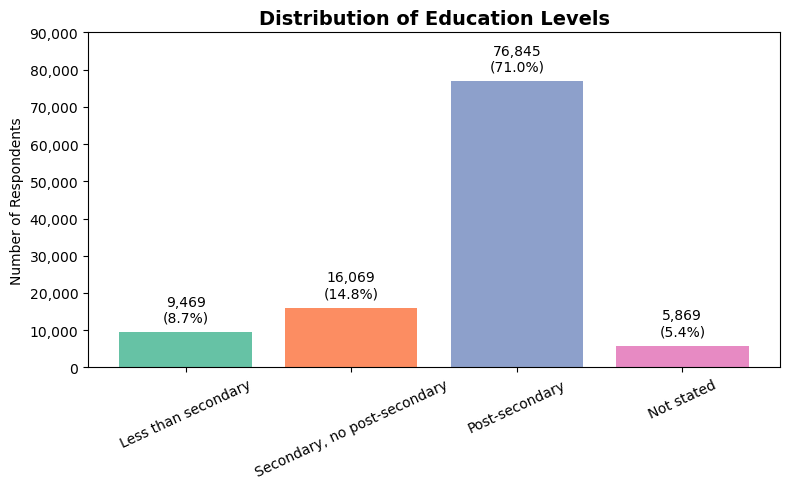

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load dataset
df = pd.read_csv("pumf_cchs.csv")

# Column of interest
edu_col = "EHG2DVH3"

# Map Education Level codes to labels
edu_labels = {
    1.0: "Less than secondary",
    2.0: "Secondary, no post-secondary",
    3.0: "Post-secondary",
    9.0: "Not stated"
}

# Convert column to float and count values
df[edu_col] = df[edu_col].astype(float)
edu_counts = df[edu_col].value_counts().sort_index()
edu_counts.index = edu_counts.index.map(edu_labels)  # replace numbers with labels

# Percentages
edu_percent = (edu_counts / edu_counts.sum()) * 100

# Plot
fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(
    edu_counts.index,
    edu_counts.values,
    color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']  # Custom colors
)

# Add counts and percentages on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + 2000,  # increase offset to avoid overlapping title
        f"{edu_counts.values[i]:,}\n({edu_percent.values[i]:.1f}%)",
        ha='center', va='bottom', fontsize=10
    )

# Labels and title
ax.set_title("Distribution of Education Levels", fontsize=14, fontweight="bold")
ax.set_ylabel("Number of Respondents")
plt.xticks(rotation=25)

# Increase y-axis limit
ax.set_ylim(0, 90000)

# Format y-axis with commas
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{int(x):,}"))

plt.tight_layout()

# Save the chart as an image
plt.savefig("education_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

### BMI by Education Level  

Created a cross-tab of BMI vs. education, then plotted a stacked bar chart showing the percentage distribution across categories.

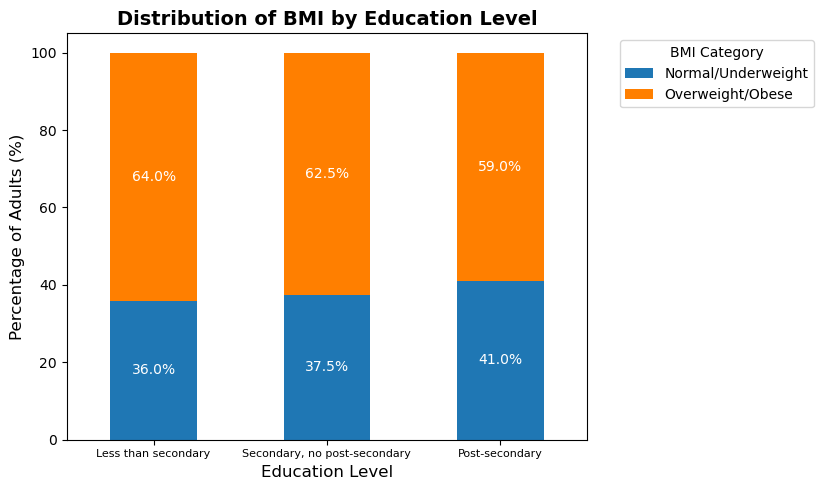

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Cross-tabulate BMI by Education
ct = pd.crosstab(df_clean['EHG2DVH3'], df_clean['HWTDGISW'], normalize='index') * 100

# Plot stacked bar chart
ax = ct.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 5),
    color=['#1f77b4', '#ff7f00']  # Optional: colors for Normal/Underweight and Overweight/Obese
)

# Add labels and title
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Percentage of Adults (%)', fontsize=12)
plt.title('Distribution of BMI by Education Level', fontsize=14, fontweight='bold')
plt.xticks(ticks=[0,1,2], labels=[
    'Less than secondary',
    'Secondary, no post-secondary',
    'Post-secondary'
], fontsize=8, rotation=0)

# Add percentages on bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    if height > 0:  # only annotate non-zero segments
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='white')

plt.legend(['Normal/Underweight', 'Overweight/Obese'], title='BMI Category', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.subplots_adjust(left=0.15, right=0.8)
plt.savefig('bmi_by_education.png', dpi=300, bbox_inches='tight')
plt.show()

### Chi-Square Test of BMI vs. Education  

Built a contingency table and ran a chi-square test to evaluate the association between BMI and education level.  

In [21]:
import pandas as pd
from scipy.stats import chi2_contingency

# Cross-tabulation with counts
ct_counts = pd.crosstab(df_clean['HWTDGISW'], df_clean['EHG2DVH3'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(ct_counts)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p:.4f}")
print("Expected counts:\n", expected)

Chi-square statistic: 121.33
Degrees of freedom: 2
P-value: 0.0000
Expected counts:
 [[ 3343.68798577  5735.23166217 26634.08035205]
 [ 5028.31201423  8624.76833783 40052.91964795]]


### Chi-Square Observed vs. Expected  

Compared observed and expected counts of BMI by education, and created a table showing differences for each category.  

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Cross-tab of cleaned data
ct = pd.crosstab(df_clean['EHG2DVH3'], df_clean['HWTDGISW'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(ct)

# Create a DataFrame for comparison
observed = ct.values
expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
diff_df = pd.DataFrame(observed - expected, index=ct.index, columns=ct.columns)

comparison_df = pd.concat([
    pd.DataFrame(observed, index=ct.index, columns=[f'Observed {c}' for c in ct.columns]),
    pd.DataFrame(expected, index=ct.index, columns=[f'Expected {c}' for c in ct.columns]),
    pd.DataFrame(observed - expected, index=ct.index, columns=[f'Diff {c}' for c in ct.columns])
], axis=1)

# Optional: format numbers with commas
comparison_df = comparison_df.applymap(lambda x: f"{int(x):,}")

comparison_df

/var/folders/_w/188tytv567j0h1wnz7p5x_sw0000gn/T/ipykernel_25913/3029644076.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  comparison_df = comparison_df.applymap(lambda x: f"{int(x):,}")


,Observed 1.0,Observed 2.0,Expected 1.0,Expected 2.0,Diff 1.0,Diff 2.0
EHG2DVH3,,,,,,
1.0,"3,011","5,361","3,343","5,028",-332,332
2.0,"5,380","8,980","5,735","8,624",-355,355
3.0,"27,322","39,365","26,634","40,052",687,-687


In [23]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Cross-tabulation of observed counts
observed = pd.crosstab(df_clean['HWTDGISW'], df_clean['EHG2DVH3'])

# Perform chi-square test to get expected counts
chi2, p, dof, expected = chi2_contingency(observed)

# Convert expected counts to DataFrame with same index/columns as observed
expected_df = pd.DataFrame(expected, index=observed.index, columns=observed.columns)

# Compute contributions to chi-square
contrib = (observed - expected_df)**2 / expected_df

# Combine into one table
report_table = pd.concat([observed.stack(), expected_df.stack(), contrib.stack()], axis=1)
report_table.columns = ['Observed', 'Expected', 'Contribution']
report_table = report_table.reset_index()
report_table.rename(columns={'HWTDGISW':'BMI', 'EHG2DVH3':'Education Level'}, inplace=True)

# Optional: map BMI and Education codes to labels
bmi_labels = {0: "Normal/Underweight", 1: "Overweight/Obese"}
edu_labels = {1: "Less than secondary", 2: "Secondary, no post-secondary", 3: "Post-secondary"}
report_table['BMI'] = report_table['BMI'].map(bmi_labels)
report_table['Education Level'] = report_table['Education Level'].map(edu_labels)

# Format numbers with commas and round contributions
report_table['Observed'] = report_table['Observed'].map('{:,}'.format)
report_table['Expected'] = report_table['Expected'].map('{:,.2f}'.format)
report_table['Contribution'] = report_table['Contribution'].map('{:.2f}'.format)

# Display the table
print(report_table)

# Optional: save as CSV
report_table.to_csv('chi_square_contributions.csv', index=False)


                BMI               Education Level Observed   Expected  \
0  Overweight/Obese           Less than secondary    3,011   3,343.69   
1  Overweight/Obese  Secondary, no post-secondary    5,380   5,735.23   
2  Overweight/Obese                Post-secondary   27,322  26,634.08   
3               NaN           Less than secondary    5,361   5,028.31   
4               NaN  Secondary, no post-secondary    8,980   8,624.77   
5               NaN                Post-secondary   39,365  40,052.92   

  Contribution  
0        33.10  
1        22.00  
2        17.77  
3        22.01  
4        14.63  
5        11.82  


### Chi-Square Contribution Heatmap  

Ran a chi-square test on BMI vs. education, calculated cell contributions, and visualized them with a heatmap.  

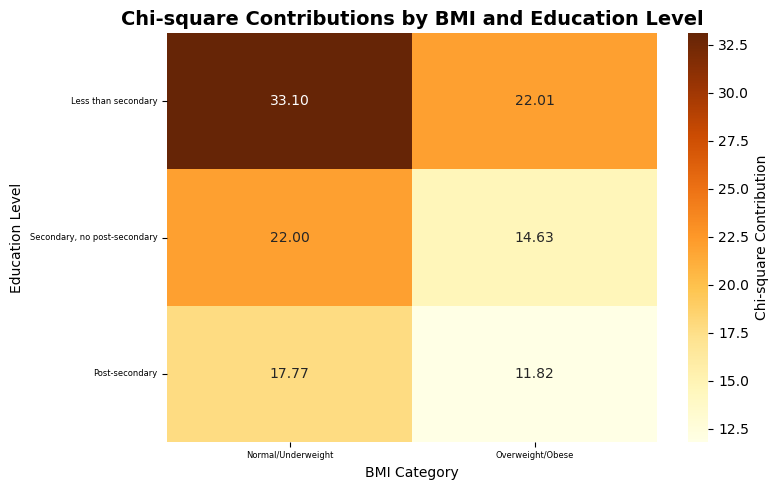

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Assume df_clean already has missing/not stated values removed

# Columns
bmi_col = 'HWTDGISW'
edu_col = 'EHG2DVH3'

# Only valid BMI categories
valid_bmi = [1, 2]  # 1 = Normal/Underweight, 2 = Overweight/Obese
observed = pd.crosstab(df_clean[edu_col], df_clean[bmi_col])  # education vs BMI counts
observed = observed[valid_bmi]  # keep only valid BMI

# Map codes to labels
bmi_labels = {1: "Normal/Underweight", 2: "Overweight/Obese"}
edu_labels = {1: "Less than secondary", 2: "Secondary, no post-secondary", 3: "Post-secondary"}

observed.columns = observed.columns.map(bmi_labels)
observed.index = observed.index.map(edu_labels)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

# Expected counts as DataFrame
expected_df = pd.DataFrame(expected, index=observed.index, columns=observed.columns)

# Contribution to Chi-square
contrib = (observed - expected_df)**2 / expected_df

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(contrib, annot=True, fmt=".2f", cmap="YlOrBr", cbar_kws={'label': 'Chi-square Contribution'})
plt.title("Chi-square Contributions by BMI and Education Level", fontsize=14, fontweight='bold')
plt.ylabel("Education Level")
plt.xlabel("BMI Category")
plt.yticks(fontsize=6, rotation=0)
plt.xticks(fontsize=6, rotation=0)
plt.tight_layout()
plt.savefig("chi_square_contributions_heatmap.png", dpi=300)
plt.show()

In [25]:
import pandas as pd
from scipy.stats import chi2_contingency

# Columns
bmi_col = 'HWTDGISW'
edu_col = 'EHG2DVH3'

# Only valid BMI categories
valid_bmi = [1, 2]  # 1 = Normal/Underweight, 2 = Overweight/Obese
observed = pd.crosstab(df_clean[edu_col], df_clean[bmi_col])
observed = observed[valid_bmi]  # keep only valid BMI

# Map codes to labels
bmi_labels = {1: "Normal/Underweight", 2: "Overweight/Obese"}
edu_labels = {1: "Less than secondary", 2: "Secondary, no post-secondary", 3: "Post-secondary"}

observed.columns = observed.columns.map(bmi_labels)
observed.index = observed.index.map(edu_labels)

# Chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

# Create DataFrames
expected_df = pd.DataFrame(expected, index=observed.index, columns=observed.columns)
contrib_df = (observed - expected_df)**2 / expected_df

# Combine all into one DataFrame for review
results_df = pd.concat([observed.add_suffix(' (Observed)'),
                        expected_df.add_suffix(' (Expected)'),
                        contrib_df.add_suffix(' (Chi2 Contrib)')], axis=1)

# Display the table
print(results_df)

HWTDGISW                      Normal/Underweight (Observed)  \
EHG2DVH3                                                      
Less than secondary                                    3011   
Secondary, no post-secondary                           5380   
Post-secondary                                        27322   

HWTDGISW                      Overweight/Obese (Observed)  \
EHG2DVH3                                                    
Less than secondary                                  5361   
Secondary, no post-secondary                         8980   
Post-secondary                                      39365   

HWTDGISW                      Normal/Underweight (Expected)  \
EHG2DVH3                                                      
Less than secondary                             3343.687986   
Secondary, no post-secondary                    5735.231662   
Post-secondary                                 26634.080352   

HWTDGISW                      Overweight/Obese (Expected)  \
E

# Hypothesis 3

### There is a significant difference in the weekly minutes of physical activity between Canadian adults with and without obesity.

### Weekly Physical Activity Minutes  

Filtered valid activity minutes, counted frequencies, and created a DataFrame (`minutes_df`) showing minutes per week and their frequency.  

In [26]:
import pandas as pd

# Filter valid values (exclude codes like 99996–99999)
valid_minutes = df.loc[df["PAADVMVA"].between(0, 6000), "PAADVMVA"]

# Count frequency of each value
minutes_counts = valid_minutes.value_counts().sort_index()

# Convert to DataFrame with proper headers
minutes_df = minutes_counts.reset_index()
minutes_df.columns = ["Minutes_per_Week", "Frequency"]

# Display first 11 rows
print(minutes_df.head(11))

    Minutes_per_Week  Frequency
0                0.0       5610
1               10.0        117
2               11.0          1
3               12.0          3
4               13.0          1
5               15.0        122
6               19.0          1
7               20.0        251
8               22.0          1
9               24.0          2
10              25.0         43


### Shapiro-Wilk Normality Test  

Tested physical activity minutes for obese vs. non-obese groups using Shapiro-Wilk and summarized results in a table.  

In [27]:
from scipy.stats import shapiro
import pandas as pd

# Ensure columns
df["PA_minutes"] = df.get("PA_minutes", df["PAADVMVA"])
df["Obesity"] = df.get("Obesity", (df["HWTDGISW"] == 2).astype(int))

# Split + subsample
pa_obese = df.loc[df["Obesity"] == 1, "PA_minutes"].dropna().sample(n=min(5000, df["Obesity"].sum()), random_state=1)
pa_nonobese = df.loc[df["Obesity"] == 0, "PA_minutes"].dropna().sample(n=min(5000, (df["Obesity"] == 0).sum()), random_state=1)

# Shapiro-Wilk
sh_obese, p_obese = shapiro(pa_obese)
sh_nonobese, p_nonobese = shapiro(pa_nonobese)

# Results
results_df = pd.DataFrame({
    "Group": ["Obese", "Non-obese"],
    "Statistic": [round(sh_obese, 3), round(sh_nonobese, 3)],
    "p-value": [f"{p_obese:.3e}", f"{p_nonobese:.3e}"]
})

display(results_df)

,Group,Statistic,p-value
0,Obese,0.498,3.028e-80
1,Non-obese,0.443,1.733e-82


### QQ Plots for Normality  

Generated QQ plots for obese and non-obese groups, including Shapiro-Wilk results, to visually assess normality of physical activity minutes.  

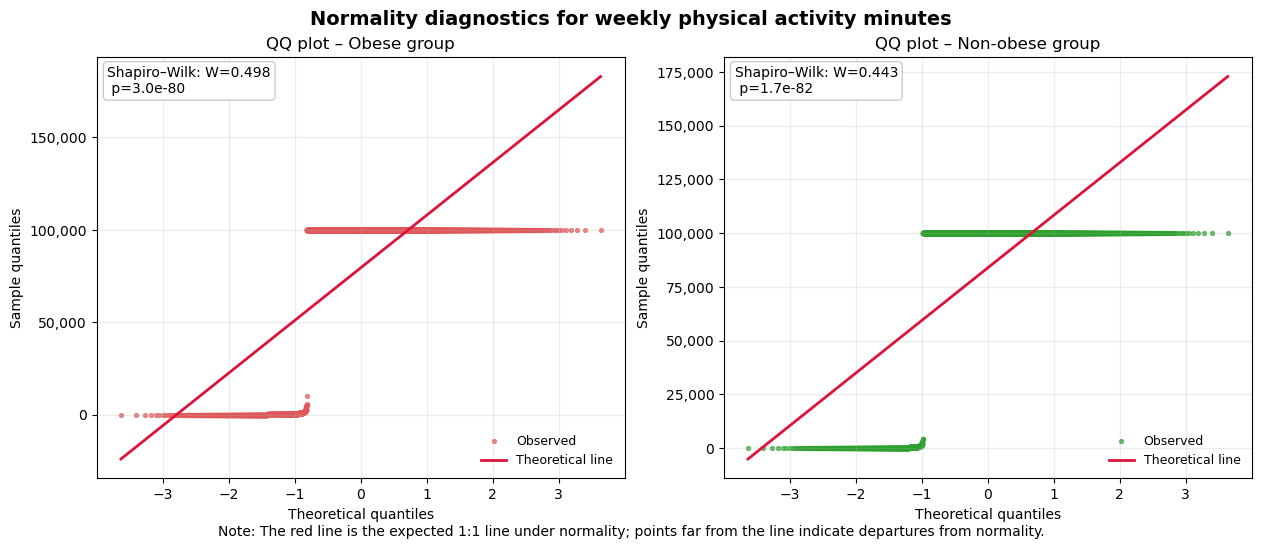

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.ticker as mtick

# pa_obese and pa_nonobese should be 1D arrays/Series of weekly minutes (cleaned, no NaNs)

def qqplot(ax, x, title, point_color, line_color="crimson"):
    # Generate theoretical vs observed quantiles
    (osm, osr), (slope, intercept, _) = stats.probplot(np.asarray(x), dist="norm")

    # Scatter plot of observed vs theoretical
    ax.scatter(osm, osr, s=8, alpha=0.65, label="Observed", color=point_color)

    # Theoretical line
    q = np.linspace(osm.min(), osm.max(), 200)
    ax.plot(q, slope*q + intercept, lw=2, label="Theoretical line", color=line_color)

    # Shapiro-Wilk normality test
    w, p = stats.shapiro(x)
    ax.text(0.02, 0.98, f"Shapiro–Wilk: W={w:.3f}\n p={p:.1e}",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=10, bbox=dict(boxstyle="round", fc="white", ec="0.8"))

    # Axis formatting
    ax.set(title=title, xlabel="Theoretical quantiles", ylabel="Sample quantiles")
    ax.grid(True, alpha=0.25)
    ax.legend(loc="lower right", frameon=False, fontsize=9)

    #  Add commas to Y axis
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12.5, 5.2), constrained_layout=True)

# QQ plots for obese and non-obese groups
qqplot(axes[0], pa_obese, "QQ plot – Obese group", point_color="#e15759")
qqplot(axes[1], pa_nonobese, "QQ plot – Non-obese group", point_color="#2ca02c")

# Overall title
fig.suptitle("Normality diagnostics for weekly physical activity minutes",
             fontsize=14, fontweight="bold")

# Note below the plots
fig.text(0.5, -0.02,
         "Note: The red line is the expected 1:1 line under normality; "
         "points far from the line indicate departures from normality.",
         ha="center", fontsize=10)

plt.show()


### Levene’s Test

Tested variance equality of physical activity minutes between obese and non-obese groups using Levene’s test.  

In [29]:
from scipy.stats import levene
import pandas as pd

# Split groups
pa_obese = df.loc[df["Obesity"] == 1, "PA_minutes"].dropna()
pa_nonobese = df.loc[df["Obesity"] == 0, "PA_minutes"].dropna()

# Levene's test
lev = levene(pa_obese, pa_nonobese)

# Results DataFrame
lev_df = pd.DataFrame({
    "Test": ["Levene's test"],
    "Statistic": [round(lev.statistic, 3)],
    "p-value": [f"{lev.pvalue:.3e}"]
})

display(lev_df)

,Test,Statistic,p-value
0,Levene's test,365.184,2.851e-81


### Welch’s t-test  

Compared mean physical activity minutes between obese and non-obese groups using Welch’s t-test.  

In [30]:
# Split groups
obese_group = df.loc[df["Obesity"] == 1, "PA_minutes"].dropna()
non_obese_group = df.loc[df["Obesity"] == 0, "PA_minutes"].dropna()

# Welch's t-test (equal_var=False)
t_stat, p_val = stats.ttest_ind(obese_group, non_obese_group, equal_var=False)

# Convert results into a DataFrame con notación científica
results_df = pd.DataFrame({
    "Test": ["Welch's t-test"],
    "t-statistic": [round(t_stat, 3)],
    "p-value": [f"{p_val:.3e}"]
})

results_df

,Test,t-statistic,p-value
0,Welch's t-test,-19.189,6.283e-82


### Descriptive measures of each group

In [31]:
df_raw = pd.read_csv("pumf_cchs.csv")

print(df_raw.columns[:50])

Index(['ADM_RNO1', 'VERDATE', 'REFPER', 'GEOGPRV', 'GEODGHR4', 'DHH_SEX',
       'DHHGMS', 'DHHDGHSZ', 'ADM_PRX', 'DHHGAGE', 'DOMAC', 'MAC_010',
       'EHG2DVH3', 'DOGEN', 'GEN_005', 'GEN_010', 'GEN_015', 'GEN_020',
       'GEN_025', 'GEN_030', 'GENDVHDI', 'GENDVMHI', 'GENDVSWL', 'DOHWT',
       'HWT_050', 'HWTDGISW', 'HWTDGWHO', 'HWTDGBCC', 'DOCCC', 'CCC_035',
       'CCC_065', 'CCC_070', 'CCC_075', 'CCC_080', 'CCC_095', 'CCC_185',
       'CCC_195', 'CCC_200', 'CCCDGRSP', 'CCCDGSKL', 'CCCDGCAR', 'DOHUI',
       'HUIDGHSI', 'HUIDGPAD', 'DOCIH', 'CIH_005', 'CIH_010', 'CIH_015',
       'CIH_020', 'CIH_025'],
      dtype='object')


### Activity Summary by Obesity  

Created a function to compute weighted stats (mean, median, SD, IQR, 95% CI) of weekly activity minutes, comparing obese vs. non-obese groups.  

In [32]:
import numpy as np
import pandas as pd

def activity_summary_by_obesity(df,
                                bmi_col="HWTDGISW",
                                pa_col="PAADVMVA",
                                weight_col="WTS_M"):
    # --- Prepare dataset ---
    need_cols = [bmi_col, pa_col] + ([weight_col] if weight_col in df.columns else [])
    df = df[need_cols].dropna()
    df["Obesity"] = (df[bmi_col] == 2).astype(int)     # 2 = obese per CCHS
    df = df[df[pa_col].between(0, 6000)]

    # --- Weighted median helper ---
    def weighted_median(x, w=None):
        x = np.asarray(x, float)
        if w is None:
            return np.median(x)
        w = np.asarray(w, float)
        order = np.argsort(x)
        xs, ws = x[order], w[order]
        cw = np.cumsum(ws) / np.sum(ws)
        return np.interp(0.5, cw, xs)

    # --- Stats helper (now returns weighted median) ---
    def weighted_stats(x, w=None, alpha=0.05):
        x = np.asarray(x, float)
        w = np.ones(len(x), float) if w is None else np.asarray(w, float)

        # weighted mean
        mean = np.sum(w * x) / np.sum(w)

        # (simple) SD & IQR kept as in your original code
        sd = np.std(x, ddof=1)
        iqr = np.percentile(x, 75) - np.percentile(x, 25)

        # CI for the (weighted) mean (same approach you had)
        se = np.sqrt(np.sum(w * (x - mean)**2) / np.sum(w)) / np.sqrt(len(x))
        z = 1.95996
        lo, hi = mean - z * se, mean + z * se

        # NEW: weighted median
        median_w = weighted_median(x, w)

        return mean, median_w, sd, iqr, lo, hi

    # --- Build output DataFrame ---
    out = []
    for g, sub in df.groupby("Obesity"):
        w = sub[weight_col] if weight_col in sub.columns else None
        mean, median_w, sd, iqr, lo, hi = weighted_stats(sub[pa_col], w)
        out.append({
            "Group": "Obese" if g == 1 else "Non-obese",
            "N": len(sub),
            "Mean min/wk": round(mean, 2),
            "Median (weighted) min/wk": round(median_w, 2),   # <- replaced
            "SD": round(sd, 2),
            "IQR": round(iqr, 2),
            "95% CI Low": round(lo, 2),
            "95% CI High": round(hi, 2),
            "Mean hr/wk": round(mean / 60, 2),
            "Mean hr/day": round(mean / 420, 2),
        })

    return pd.DataFrame(out)


In [33]:
df_summary = activity_summary_by_obesity(df_raw)
df_summary

,Group,N,Mean min/wk,Median (weighted) min/wk,SD,IQR,95% CI Low,95% CI High,Mean hr/wk,Mean hr/day
0,Non-obese,8510,400.03,210.0,546.31,400.0,387.44,412.62,6.67,0.95
1,Obese,11854,390.67,200.0,559.17,420.0,380.11,401.24,6.51,0.93


### Physical Activity by Obesity Status  

Plotted mean weekly activity minutes for obese vs. non-obese groups with 95% confidence intervals as error bars.  

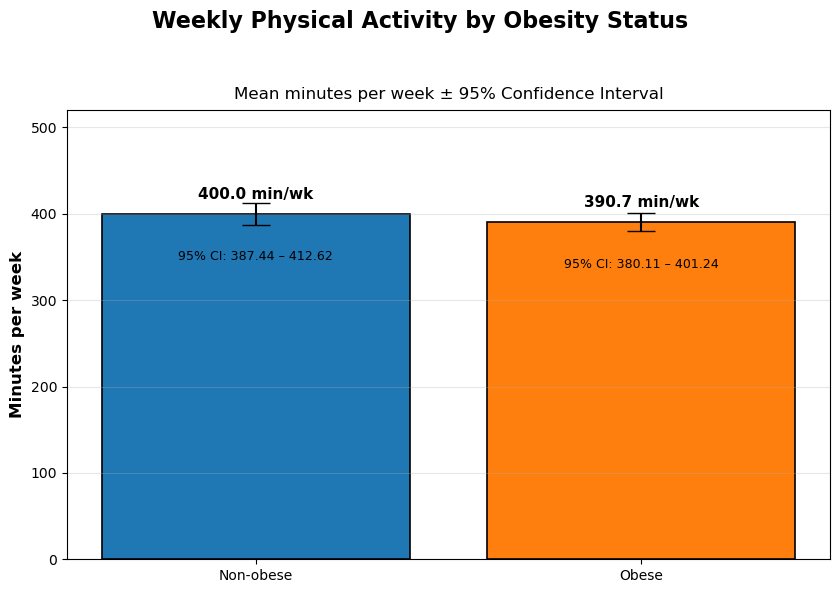

Saved to: /Users/carlosdavid/Desktop/carpeta sin título/figures/slide1_activity_bar_noWHO.png


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

data = [
    {"Group": "Non-obese", "Mean": 400.03, "CI_low": 387.44, "CI_high": 412.62},
    {"Group": "Obese",     "Mean": 390.67, "CI_low": 380.11, "CI_high": 401.24},
]
df = pd.DataFrame(data)
df["yerr"] = df["Mean"] - df["CI_low"]  # (IC 95%)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8.5, 6))

# Colors and bars
colors = ["#1f77b4", "#ff7f0e"]
bars = ax.bar(
    df["Group"], df["Mean"],
    yerr=df["yerr"], capsize=10,
    linewidth=1.2, edgecolor="black",
    color=colors
)

# Titles and labels
plt.suptitle("Weekly Physical Activity by Obesity Status", fontsize=16, fontweight="bold", y=0.98)
ax.set_title("Mean minutes per week ± 95% Confidence Interval", fontsize=12, pad=8)
ax.set_ylabel("Minutes per week", fontsize=12, fontweight="bold")
ax.set_ylim(0, max(df["CI_high"].max() + 60, 520))
ax.grid(axis="y", alpha=0.3)

# Value labels
for bar, (_, row) in zip(bars, df.iterrows()):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 14,
            f"{row['Mean']:.1f} min/wk",
            ha="center", va="bottom", fontsize=11, fontweight="bold")
    ax.text(bar.get_x() + bar.get_width()/2, h - 42,
            f"95% CI: {row['CI_low']:.2f} – {row['CI_high']:.2f}",
            ha="center", va="top", fontsize=9, color="black")

plt.tight_layout(rect=[0, 0, 1, 0.94])

# Save the figure
out_dir = Path("figures")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "slide1_activity_bar_noWHO.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved to: {out_path.resolve()}")

# Hypothesis 4 

There is a significant relationship between higher alcohol consumption and obesity classification among Canadian adults. Higher alcohol consumption is associated with an increased risk of obesity, possibly due to its negative effects on metabolism and overall health.


### Preparing BMI and Alcohol Variables

This step prepares the BMI classification (`HWTDGISW`) and alcohol consumption (`ALWDVWKY`) variables for analysis by selecting, cleaning, and structuring them properly before descriptive or inferential tests.


In [35]:
# ============================================================
# Step 1 — Imports & display config
# Uses only HWTDGISW for BMI and ALWDVWKY for alcohol categories
# Output: no printed output (environment setup)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


### Exploring BMI Distribution by Alcohol Intake

This step summarizes how BMI categories are distributed across alcohol groups using cross-tabulations and descriptive tables, giving an initial view of patterns in the data.


In [38]:
# ============================================================
# Step 2 — Load data with ONLY needed columns
# Output: preview and shape
# >>> Update DATA_PATH as needed <<<
# ============================================================
DATA_PATH = "pumf_cchs.csv"  # e.g., r"C:\path\to\pumf_cchs.csv"

df = pd.read_csv(DATA_PATH, usecols=["HWTDGISW", "ALWDVWKY"], low_memory=False)
print(df.head(3))
print("Shape:", df.shape)

   HWTDGISW  ALWDVWKY
0       1.0     996.0
1       2.0     996.0
2       2.0     996.0
Shape: (108252, 2)


### Visualizing the Relationship

A bar or stacked chart is generated to compare normal/underweight versus overweight/obese proportions across alcohol groups, making differences easier to interpret visually.


In [ ]:
# ============================================================
# Step 3 — Keep valid BMI codes and label BMI
# HWTDGISW: 1 = Normal/Underweight, 2 = Overweight/Obese
# Output: counts by BMI label
# ============================================================
df = df[df["HWTDGISW"].isin([1, 2])].copy()
df["BMI_LAB"] = df["HWTDGISW"].map({1: "Normal/Underweight", 2: "Overweight/Obese"})
print(df["BMI_LAB"].value_counts(dropna=False))

BMI_LAB
Overweight/Obese      56516
Normal/Underweight    37555
Name: count, dtype: int64


### Testing the Association (Chi-square)

A chi-square test of independence compares observed and expected frequencies to test whether BMI classification is associated with alcohol consumption level.


In [ ]:
# ============================================================
# Step 4 — Create Alcohol Consumption Categories from ALWDVWKY
# Categories: None (0), Low (1–7), Moderate (8–14), High (15+)
# Output: quick sanity cross-counts
# ============================================================
df["ALWDVWKY"] = pd.to_numeric(df["ALWDVWKY"], errors="coerce")

# Replace special codes (996–999) with NaN
df.loc[df["ALWDVWKY"].between(996, 999), "ALWDVWKY"] = np.nan

# Categorize
def alc_cat(x):
    if pd.isna(x):
        return np.nan
    if x == 0:
        return "None"
    elif 1 <= x <= 7:
        return "Low (1–7)"
    elif 8 <= x <= 14:
        return "Moderate (8–14)"
    else:
        return "High (15+)"

df["ALC_CAT"] = df["ALWDVWKY"].apply(alc_cat)

print(df["ALC_CAT"].value_counts(dropna=False))

ALC_CAT
NaN                60288
Low (1–7)          15270
None               12559
Moderate (8–14)     3685
High (15+)          2269
Name: count, dtype: int64


### Validating the Chi-square Assumptions

We verify that chi-square assumptions are satisfied: categorical variables, independent observations, and expected cell counts ≥ 5, ensuring valid inference.


In [ ]:
# ============================================================
# Step 5 — (counts) and (row proportions)
# Output: printed tables; also stores table1_props for plotting
# ============================================================
tab = pd.crosstab(df["ALC_CAT"], df["BMI_LAB"])
prop_row = tab.div(tab.sum(axis=1), axis=0).round(3)

print("Counts of BMI categories by Alcohol Consumption Level")
display(tab)

print("\nRow Proportions of BMI categories within Alcohol Consumption Level")
display(prop_row)

table1_props = prop_row.copy()

Counts of BMI categories by Alcohol Consumption Level


BMI_LAB,Normal/Underweight,Overweight/Obese
ALC_CAT,,
High (15+),859,1410
Low (1–7),6679,8591
Moderate (8–14),1551,2134
None,5004,7555



Row Proportions of BMI categories within Alcohol Consumption Level


BMI_LAB,Normal/Underweight,Overweight/Obese
ALC_CAT,,
High (15+),0.379,0.621
Low (1–7),0.437,0.563
Moderate (8–14),0.421,0.579
None,0.398,0.602


### Identifying Contributing Groups (Standardized Residuals)

Standardized residuals identify which alcohol consumption groups deviate most from expectation—positive residuals indicate more cases than expected, negative residuals indicate fewer.


In [ ]:
# ============================================================
# Step 6 — Prevalence of Overweight/Obese by alcohol level (95% CI)
# Output: prevalence table prev_df
# ============================================================
from math import sqrt

def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    p = k/n
    denom = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half = (z*sqrt((p*(1-p)/n) + (z**2/(4*n**2)))) / denom
    return center - half, center + half

rows = []
for g, sub in df.groupby("ALC_CAT"):
    n = len(sub)
    k = (sub["BMI_LAB"] == "Overweight/Obese").sum()
    p = k/n if n>0 else np.nan
    lo, hi = wilson_ci(k, n)
    rows.append({
        "ALC_CAT": g,
        "N": n,
        "Overweight/Obese (%)": round(p*100, 1),
        "95% CI lower (%)": round(lo*100, 1),
        "95% CI upper (%)": round(hi*100, 1)
    })

prev_df = pd.DataFrame(rows).sort_values("ALC_CAT").reset_index(drop=True)
print("Prevalence of Overweight/Obese by Alcohol Level (95% CI)")
display(prev_df)

Prevalence of Overweight/Obese by Alcohol Level (95% CI)


,ALC_CAT,N,Overweight/Obese (%),95% CI lower (%),95% CI upper (%)
0,High (15+),2269,62.1,60.1,64.1
1,Low (1–7),15270,56.3,55.5,57.0
2,Moderate (8–14),3685,57.9,56.3,59.5
3,None,12559,60.2,59.3,61.0


### Using BMI as a Continuous Measure

BMI is also analyzed as a continuous variable (means, medians, and prevalence with 95% CIs) to provide a more detailed perspective alongside categorical results.


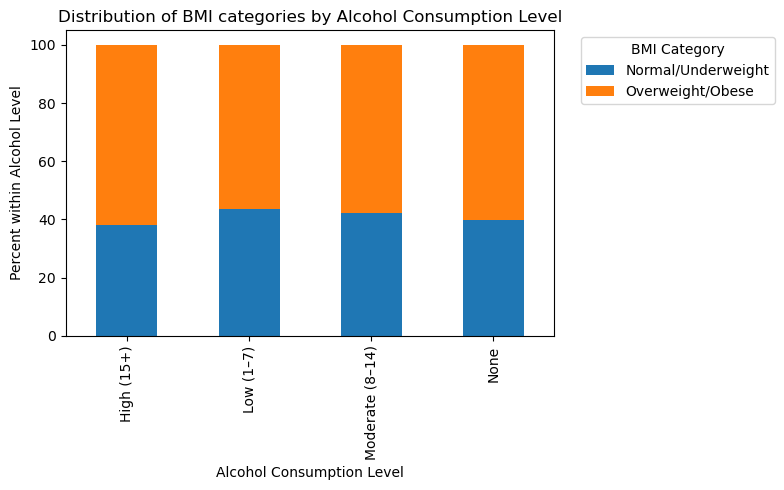

In [ ]:
# ============================================================
# Step 7 — Stacked bars (% within alcohol level)
# Output: chart (matplotlib only; one chart per cell; no manual colors)
# ============================================================
ax = (table1_props * 100).plot(kind="bar", stacked=True, figsize=(8,5))
ax.set_title("Distribution of BMI categories by Alcohol Consumption Level")
ax.set_ylabel("Percent within Alcohol Level")
ax.set_xlabel("Alcohol Consumption Level")
ax.legend(title="BMI Category", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Additional Visualization

This step generates supplementary plots to clarify trends and differences relevant to Hypothesis 4.


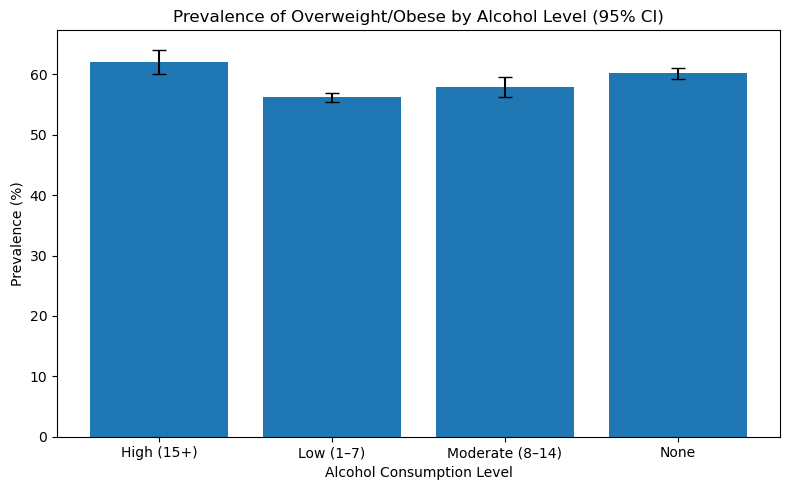

In [ ]:
# ============================================================
# Step 8 (Updated) — Bar Chart of Prevalence with 95% CI
# Output: bar chart with error bars
# ============================================================
plt.figure(figsize=(8,5))

x = np.arange(prev_df.shape[0])
y = prev_df["Overweight/Obese (%)"].values
yerr_lower = y - prev_df["95% CI lower (%)"].values
yerr_upper = prev_df["95% CI upper (%)"].values - y

# plot as bar chart
bars = plt.bar(x, y, yerr=[yerr_lower, yerr_upper], capsize=5)

plt.xticks(x, prev_df["ALC_CAT"])
plt.title("Prevalence of Overweight/Obese by Alcohol Level (95% CI)")
plt.ylabel("Prevalence (%)")
plt.xlabel("Alcohol Consumption Level")
plt.tight_layout()
plt.show()

### Additional Statistical Checks

This step adds complementary statistical checks to validate or extend the primary chi-square findings.


In [ ]:
# ============================================================
# Step 9 — Chi-square test (χ², df, p) + Cramer's V
# Output: prints χ², df, N, p-value, Cramer's V
# ============================================================
chi_tab = pd.crosstab(df["ALC_CAT"], df["BMI_LAB"])
chi2, p, dof, expected = chi2_contingency(chi_tab.values)
N = chi_tab.values.sum()

min_dim = min(chi_tab.shape) - 1
cramers_v = np.sqrt(chi2 / (N * min_dim)) if min_dim > 0 else np.nan

print("Chi-square test of independence (Alcohol × BMI)")
print(f"Chi-square statistic = {chi2:.2f}")
print(f"Degrees of freedom   = {dof}")
print(f"Sample size (N)      = {N}")
print(f"p-value              = {p:.4g}")
print(f"Cramer's V           = {cramers_v:.3f}")

Chi-square test of independence (Alcohol × BMI)
Chi-square statistic = 57.92
Degrees of freedom   = 3
Sample size (N)      = 33783
p-value              = 1.639e-12
Cramer's V           = 0.041


# Hypothesis **5**

Canadian adults with high levels of stress are more likely to experience obesity, possibly because stress can disrupt hormone regulation which may contribute to weight gain.

### Hypothesis 5: Stress Levels and Obesity

This section investigates the relationship between stress levels and the likelihood of obesity among Canadian adults. The hypothesis is that higher stress levels are associated with an increased probability of being overweight or obese.

### Data Loading and Initial Filtering

We load the dataset and perform initial filtering to exclude categories like 'Dont know', 'Refusal', and 'Valid Skip' from the stress level variable (`GEN_020`) and 'Not stated', 'Valid skip' from the BMI category variable (`HWTDGBCC`). This ensures that our analysis focuses on valid responses for both variables.

### Filtered Contingency Table

A contingency table is created using the filtered data to show the counts of each combination of stress level and BMI category. This table is the basis for further statistical analysis.

**Filtered Contingency Table:**
| GEN_020               | Overweight / Obese - Class I, II, III   | Underweight / Normal weight   |
|:----------------------|:----------------------------------------|:------------------------------|
| A bit stressful       | 1345                                    | 679                           |
| Extremely stressful   | 125                                     | 47                            |
| Not at all stressful  | 639                                     | 269                           |
| Not very stressful    | 982                                     | 447                           |
| Quite a bit stressful | 575                                     | 250                           |

In [ ]:
import pandas as pd

# Load the dataframe with a different encoding, such as 'latin-1'
try:
    df = pd.read_csv('/content/Hypotheses 5 Categorical values final.csv', encoding='latin-1')
except UnicodeDecodeError:
    # If 'latin-1' fails, try another common encoding like 'cp1252'
    try:
        df = pd.read_csv('/content/Hypotheses 5 Categorical values final.csv', encoding='cp1252')
    except Exception as e:
        print(f"Could not decode the file with common encodings: {e}")
        # Optionally, you might want to investigate the file encoding further
        # or inform the user that the file encoding is problematic.
        exit() # Exit or handle the error appropriately if decoding fails

import pandas as pd

# Load the dataframe.
df = pd.read_csv('/content/Hypotheses 5 Categorical values final.csv')

# Define the categories to exclude
exclude_gen_020 = ['Dont know', 'Refusal', 'Valid Skip']
exclude_hwt_gbcc = ['Not stated', 'Valid skip']

# Filter the dataframe to exclude unwanted categories from both columns
df_filtered = df[~df['GEN_020'].isin(exclude_gen_020)]
df_filtered = df_filtered[~df_filtered['HWTDGBCC'].isin(exclude_hwt_gbcc)]

# Create a new contingency table with the filtered data
contingency_table_filtered = pd.crosstab(df_filtered['GEN_020'], df_filtered['HWTDGBCC'])

# Display the new contingency table.
print("Filtered Contingency Table:")
print(contingency_table_filtered.to_markdown(numalign="left", stralign="left"))

# Save the new table to a CSV file
contingency_table_filtered.to_csv('contingency_table_filtered.csv')

Filtered Contingency Table:
| GEN_020               | Overweight / Obese - Class I, II, III   | Underweight / Normal weight   |
|:----------------------|:----------------------------------------|:------------------------------|
| A bit stressful       | 1345                                    | 679                           |
| Extremely stressful   | 125                                     | 47                            |
| Not at all stressful  | 639                                     | 269                           |
| Not very stressful    | 982                                     | 447                           |
| Quite a bit stressful | 575                                     | 250                           |


### Odds Ratio Calculation (Extremely Stressful vs. Not at All Stressful)

To quantify the association between stress and obesity, we calculate the odds ratio comparing the 'Extremely stressful' group to the 'Not at all stressful' group. An odds ratio greater than 1 suggests higher odds of the outcome (obesity) in the exposed group (extremely stressful).

**Results:**
Odds Ratio: 1.12
Odds Ratio (via statsmodels): 1.12

The odds ratio of 1.12 suggests that individuals reporting 'Extremely stressful' lives have slightly higher odds of being overweight or obese compared to those reporting 'Not at all stressful' lives. However, the magnitude of this effect is small.

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import Table2x2

# Load the filtered contingency table
contingency_table_filtered = pd.read_csv('contingency_table_filtered.csv', index_col='GEN_020')

# Select two rows for comparison to create a 2x2 table
# Comparing 'Extremely stressful' vs. 'Not at all stressful'
# Using the correct index labels from the contingency table
df_odds = contingency_table_filtered.loc[['Extremely stressful', 'Not at all stressful']].copy()

# Select only the relevant BMI outcome columns for the odds ratio calculation
# Assuming 'Overweight / Obese - Class I, II, III' and 'Underweight / Normal weight' are the relevant outcome categories
if 'Overweight / Obese - Class I, II, III' in df_odds.columns and 'Underweight / Normal weight' in df_odds.columns:
    df_odds = df_odds[['Overweight / Obese - Class I, II, III', 'Underweight / Normal weight']]

    # Extract values for the odds ratio formula
    # Assuming the order of columns is Overweight/Obese then Normal/Underweight
    # Based on the common presentation for odds ratio (Outcome 1 vs Outcome 2)
    A = df_odds.loc['Extremely stressful', 'Overweight / Obese - Class I, II, III']  # Exposed, Outcome 1 (Obese)
    B = df_odds.loc['Extremely stressful', 'Underweight / Normal weight']     # Exposed, Outcome 2 (Non-obese)
    C = df_odds.loc['Not at all stressful', 'Overweight / Obese - Class I, II, III'] # Not Exposed, Outcome 1 (Obese)
    D = df_odds.loc['Not at all stressful', 'Underweight / Normal weight']    # Not Exposed, Outcome 2 (Non-obese)


    # Calculate the odds ratio
    # Add a small epsilon to avoid division by zero in case of zero counts in B or C
    epsilon = 1e-9
    if (B + epsilon) * (C + epsilon) == 0:
         odds_ratio = np.nan
         print("Cannot calculate odds ratio due to zero counts in denominator.")
    else:
        odds_ratio = (A * D) / ((B + epsilon) * (C + epsilon)) # Added epsilon for robust calculation

    print(f"Odds Ratio: {odds_ratio:.2f}")

    # You can also use a library for a professional calculation
    # Ensure the table for statsmodels is in the correct format: [[a, b], [c, d]]
    # where a = exposed, outcome 1; b = exposed, outcome 2; c = unexposed, outcome 1; d = unexposed, outcome 2
    table = np.array([[A, B], [C, D]])
    try:
        odds_ratio_statsmodels = Table2x2(table).oddsratio
        print(f"Odds Ratio (via statsmodels): {odds_ratio_statsmodels:.2f}")
        # Optionally, calculate confidence intervals for the odds ratio using statsmodels
        # odds_ci = Table2x2(table).oddsratio_ci(alpha=0.05)
        # print(f"95% CI for Odds Ratio: ({odds_ci[0]:.2f}, {odds_ci[1]:.2f})")
    except Exception as e:
        print(f"Error calculating odds ratio via statsmodels: {e}")

else:
    print("Error: Required BMI outcome columns not found in the filtered contingency table.")
    print("Available columns:", df_odds.columns.tolist())

Odds Ratio: 1.12
Odds Ratio (via statsmodels): 1.12


### Chi-Square Test of Independence

A chi-square test of independence is performed on the filtered contingency table to determine if there is a statistically significant association between stress levels and BMI categories.

**Results:**
Chi-square statistic: 7.35
Degrees of freedom: 4
P-value: 0.12

The chi-square statistic is 7.35 with 4 degrees of freedom. The p-value is 0.12, which is greater than the conventional significance level of 0.05. This indicates that there is no statistically significant evidence to conclude a dependency between stress levels (as categorized in this dataset) and BMI categories based on this test.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

# Load the contingency table from the previous step
contingency_table = pd.read_csv('/content/contingency_table_filtered.csv', index_col='GEN_020')
#pd.crosstab(df['GEN_020'], df['HWTDGBCC'])

# Perform the chi-square test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.2f}")
print(f"Degrees of freedom: {dof}")

Chi-square statistic: 7.35
P-value: 0.12
Degrees of freedom: 4


### Visualizing BMI by Stress Level

A grouped bar chart is generated to visualize the counts of each BMI category within each stress level. This provides a visual representation of the data distribution and helps in understanding the relationship between the two variables.

The chart shows the raw counts for each stress level and BMI category. While there are variations in counts across stress levels, the chi-square test suggests these differences are not statistically significant enough to conclude a strong association in the overall population based on this sample and categorization.

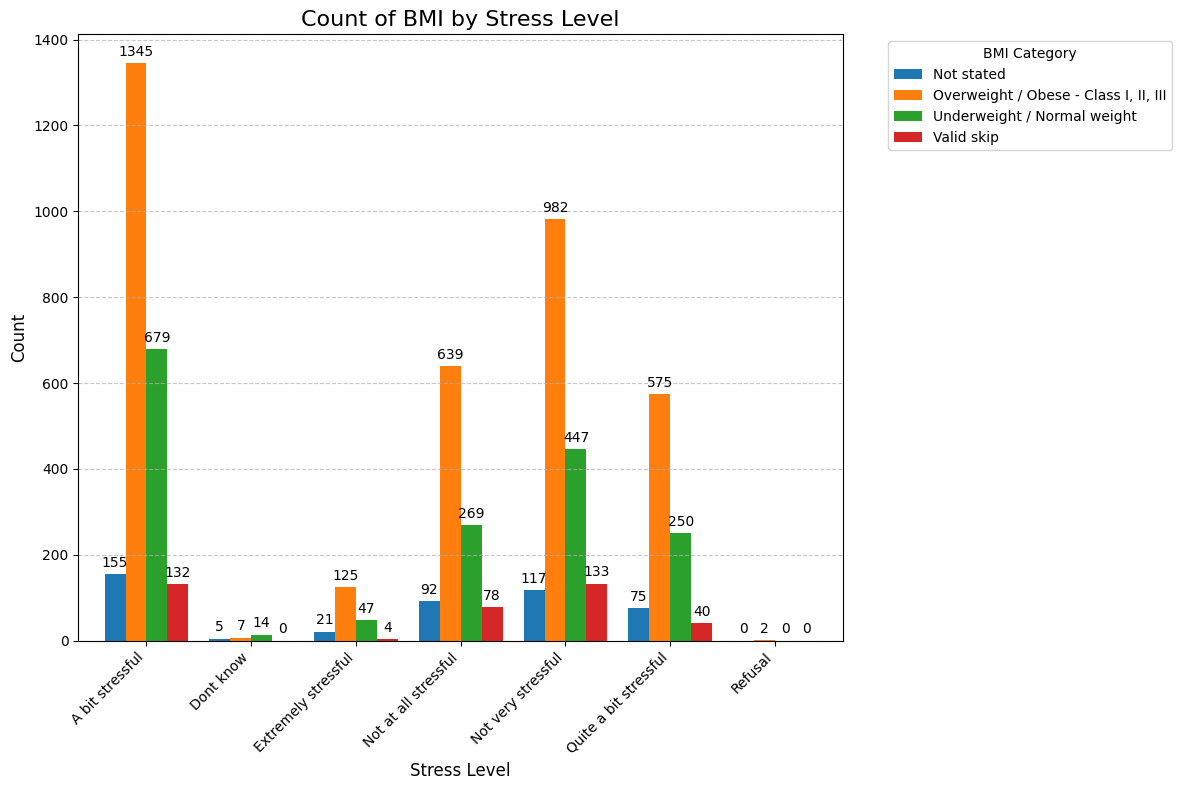

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataframe
df = pd.read_csv('/content/Hypotheses 5 Categorical values final.csv')

# Create a contingency table with raw counts
contingency_counts = pd.crosstab(df['GEN_020'], df['HWTDGBCC'])

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 8))
contingency_counts.plot(kind='bar', ax=ax, width=0.8)

# Set plot title and labels
ax.set_title('Count of BMI by Stress Level', fontsize=16)
ax.set_xlabel('Stress Level', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add the counts on top of each bar
for c in ax.containers:
    ax.bar_label(c, label_type='edge', padding=3)

# Add gridlines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Move the legend outside the plot
ax.legend(title='BMI Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save the plot
plt.savefig('grouped_bar_chart.png')